In [12]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import itertools
from skimage import io
import math
import matplotlib.pyplot as plt 
import numpy as np
import os
import pickle
import pandas as pd
from PIL import Image, ImageOps

In [13]:
# Path to folder where images are stored
dataset_dir = "/gpfs/scratch/ms15516/dl4med-project/data/extracted-data/images"

In [14]:
if torch.cuda.is_available:
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(f"Device: {device}")

Device: cuda


In [15]:
# Create datasets:
label_names = ["Atelectasis", "Cardiomegaly", "Consolidation", "Edema", "Effusion", "Emphysema", "Fibrosis", "Hernia", "Infiltration", "Mass", "No Finding", "Nodule", "Pleural_Thickening", "Pneumonia", "Pneumothorax"]

train_df =  pd.read_csv("../../input/train.csv")
val_df = pd.read_csv("../../input/val.csv")
test_df = pd.read_csv("../../input/test.csv")


In [16]:
import torchvision.models as models

model_resnet = models.resnet50(weights='IMAGENET1K_V2').to(device)
print(model_resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [17]:
class customNormalization(nn.Module):
    def __init__(self, mean, std):
        super().__init__()
        self.mean = mean
        self.std = std

    def forward(self, x):
        # print(f"original mean: {torch.mean(torch.flatten(x))}")
        # print(f"original std: {torch.std(torch.flatten(x))}")
        normalized_x = x*self.std + self.mean
        # print(f"new mean: {torch.mean(torch.flatten(normalized_x))}")
        # print(f"new std: {torch.std(torch.flatten(normalized_x))}")
        return normalized_x

In [18]:
# Remove output layer / classifier layer from model, but save expected size
original_fc_input_size = model_resnet.fc.in_features
model_resnet.fc = nn.Identity ()

print(f"original_fc_input_size: {original_fc_input_size}")

# Add additional convolutional layers at the beginning to change input size from [1, 1024, 1024] to [3, 224, 224]
input_layer = model_resnet.conv1
# Also use a custom normalization layer to match expected input distributions of pre-trained ResNet
# For simplicity, average across RGB channels, since the values are similar
imagenet_mean = np.mean([0.485, 0.456, 0.406])
imagenet_std = np.mean([0.229, 0.224, 0.225])
normalization_layer = customNormalization(imagenet_mean, imagenet_std)

new_input_layer = nn.Sequential(
    nn.Conv2d(1, 32, kernel_size=5, stride=2, padding=0),
    nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
    nn.ReLU(),
    nn.Conv2d(32, 16, kernel_size=7, stride=2, padding=0),
    nn.BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
    nn.ReLU(),
    nn.Conv2d(16, input_layer.in_channels, kernel_size=9, stride=1, padding=0),
    nn.BatchNorm2d(input_layer.in_channels, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
    normalization_layer,
    input_layer
)

model_resnet.conv1 = new_input_layer.to(device)

original_fc_input_size: 2048


In [19]:
class ResNetConcatHiddenState(nn.Module):
    def __init__(self, resnet_model, original_fc_input_size, num_classes):
        super(ResNetConcatHiddenState, self).__init__()
        self.resnet = resnet_model
        self.classifier = nn.Linear(original_fc_input_size + 3, num_classes)  # +3 for age, sex, view

    def forward(self, image, metadata):
        # Get resnet output (ie. final hidden state)
        resnet_output = self.resnet(image)
        # print(f"hidden state shape: {resnet_output.size()}")
        
        # Add metadata
        age = metadata[:, 0].unsqueeze(dim=1)  # Make sure age is of shape (batch_size, 1)
        sex = metadata[:, 1].unsqueeze(dim=1) # Make sure sex is of shape (batch_size, 1)
        view = metadata[:, 2].unsqueeze(dim=1) # Make sure view is of shape (batch_size, 1)

        # Concatenate hidden state with age and sex (assumes sex is already encoded or a scalar)
        combined = torch.cat((resnet_output, age, sex, view), dim=1)
        # print(f"hidden state + metadata shape: {combined.size()}")

        # Classification head
        logits = self.classifier(combined)
        
        return logits


In [20]:
# Load previously trained model from file
num_classes = len(label_names)
model_resnet_trained = ResNetConcatHiddenState(model_resnet, original_fc_input_size, num_classes)
model_resnet_trained.load_state_dict(torch.load('../../output/model_resnet50_log_weights_conv_input.pth'))
model_resnet_trained.to(device)

# Load data from the pickle files
with open('../../output/acc_dict_resnet50_log_weights_conv_input.pkl', 'rb') as file:
    acc_dict = pickle.load(file)

with open('../../output/loss_dict_resnet50_log_weights_conv_input.pkl', 'rb') as file:
    loss_dict = pickle.load(file)

print(acc_dict)
print(loss_dict)

{'train': [0.9300983707486227, 0.9329548798319593, 0.9332409834358689, 0.9333070769899365, 0.9333849406289753, 0.9336031398965138, 0.9336991113585847, 0.9338367308136297, 0.9339218375818813, 0.9342016034477295, 0.9343093449947714, 0.9346035971190454, 0.9348562012503452, 0.9350780220824901, 0.9351839528472288, 0.935737146840864, 0.936370015255841, 0.936645254165931, 0.9373188651827306, 0.9373731886518273], 'validate': [0.9313681379774003, 0.9334419362345823, 0.9345124505468931, 0.9277894138029116, 0.9260155664158457, 0.9302252217309234, 0.925177772606211, 0.9323041915548316, 0.9308458097380602, 0.9310009567398443, 0.9327592894267318, 0.9330540687301218, 0.9309285548056784, 0.9279962764719571, 0.9237659348899749, 0.926025909549298, 0.9244123807307424, 0.926062110516381, 0.9250329687378791, 0.9255863263775761]}
{'train': [0.022775714529761966, 0.021552378651049663, 0.020914245991690786, 0.020414276150304857, 0.020038625305932888, 0.019703086361008607, 0.019404182980242754, 0.0191338346307

In [21]:
avg_age = train_df['Patient Age'].mean()
std_age = train_df['Patient Age'].std()

def normalize_age(age):
    return (age - avg_age) / std_age

In [22]:
class ChestXrayDataset(Dataset):
    def __init__(self, df, label_names, image_dir, transform):

        self.df = df.reset_index(drop=True)
        # print(self.df.head())
        # print(self.df.columns)
        
        self.image_dir = image_dir
        self.transform = transform
        self.labels = df[label_names].values

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):

        # Extract and normalize metadata
        metadata = self.df.loc[idx, ['Patient Age', 'Patient Sex', 'View Position']].to_list()
        metadata[0] = normalize_age(metadata[0])
        metadata[1] = 1 if metadata[1] == 'M' else 0
        metadata[2] = 1 if metadata[2] == 'AP' else 0
        metadata = torch.tensor(metadata).float()
        
        # Load and process the image
        img_name = self.df.loc[idx, "Image Index"]
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert("L")
        image = self.transform(image)

        label = torch.tensor(self.labels[idx]).float()
        
        return image, metadata, label


In [23]:
# -----------------------------
# Transforms
# -----------------------------
train_transform = transforms.Compose([
    # transforms.Resize((224, 224)),
    # transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0], [1])
])

val_test_transform = transforms.Compose([
    # transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0], [1])
])


 - - - - Sample Image Pixel Values - - - - 
tensor([[[[0.0627, 0.0980, 0.0863,  ..., 0.2863, 0.3137, 0.1843],
          [0.1255, 0.2039, 0.1765,  ..., 0.5804, 0.6275, 0.3608],
          [0.1176, 0.1922, 0.1647,  ..., 0.5255, 0.5529, 0.3216],
          ...,
          [0.4471, 0.7882, 0.7529,  ..., 0.7294, 0.7882, 0.4627],
          [0.4784, 0.8471, 0.8118,  ..., 0.7569, 0.8235, 0.4824],
          [0.2314, 0.4078, 0.3922,  ..., 0.3647, 0.3961, 0.2314]]],


        [[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],


        [[[0.0000, 0.0000, 0.0000,  ..., 0.3412, 0.4078, 0.4941],
          [0.0000, 0.0000, 0.0000,  ..., 0.2941, 0.3569, 0.4

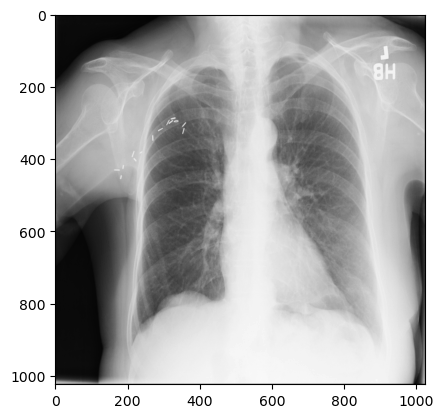

In [24]:
train_ds = ChestXrayDataset(train_df, label_names, dataset_dir, train_transform)
val_ds = ChestXrayDataset(val_df, label_names, dataset_dir, val_test_transform)
test_ds = ChestXrayDataset(test_df, label_names, dataset_dir, val_test_transform)

# Create dataloaders:
train_loader = DataLoader(train_ds, batch_size = 32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size = 32)
test_loader = DataLoader(test_ds, batch_size = 32)

# Check that dataloader works as expected:
torch.manual_seed(123)
temp_data = next(iter(test_loader))

temp_img = temp_data[0]
temp_metadata = temp_data[1]
temp_label = temp_data[2]

print(" - - - - Sample Image Pixel Values - - - - ")
print(temp_img)
print(" - - - - - - - - - ")
print(f"temp_img shape: {temp_img.shape}")
plt.imshow(temp_img[0,0,:,:], cmap='gray')
print(f"temp_metadata: {temp_metadata[0]}")
print(f"temp_label shape: {temp_label.shape}")
print(f"temp_label: {temp_label[0]}")

In [25]:
print(f"Number of imges in training dataset: {len(train_ds)}")
print(f"Number of imges in validation dataset: {len(val_ds)}")
print(f"Number of imges in test dataset: {len(test_ds)}")

Number of imges in training dataset: 73633
Number of imges in validation dataset: 12891
Number of imges in test dataset: 25596


In [26]:
train_df_totals = train_df[label_names].sum()/len(train_df)*100

print(f"Percentage of positive cases in training dataset:")
train_df_totals


Percentage of positive cases in training dataset:


Atelectasis            9.434628
Cardiomegaly           1.985523
Consolidation          3.259408
Edema                  1.613407
Effusion               9.952060
Emphysema              1.628346
Fibrosis               1.435498
Hernia                 0.169761
Infiltration          15.943938
Mass                   4.679967
No Finding            58.475140
Nodule                 5.460867
Pleural_Thickening     2.577649
Pneumonia              1.021281
Pneumothorax           3.019027
dtype: float64

In [27]:
test_df_totals = test_df[label_names].sum()/len(test_df)*100

print(f"Percentage of positive cases in testing dataset:")
test_df_totals

Percentage of positive cases in testing dataset:


Atelectasis           12.810595
Cardiomegaly           4.176434
Consolidation          7.090952
Edema                  3.613846
Effusion              18.198156
Emphysema              4.270198
Fibrosis               1.699484
Hernia                 0.335990
Infiltration          23.878731
Mass                   6.829192
No Finding            38.525551
Nodule                 6.340835
Pleural_Thickening     4.465541
Pneumonia              2.168308
Pneumothorax          10.411783
dtype: float64

In [28]:
# Define functions to plot accuracy and loss over training epochs

def plot_loss(ax, loss, title):
    x = np.arange(1, len(loss)+1)
    # plt.figure(dpi=150)
    ax.plot(x, loss)
    ax.set_title(title)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    # plt.show()

def plot_accuracy(ax, accuracy, title):
    x = np.arange(1, len(accuracy)+1)
    # plt.figure(dpi=150)
    ax.plot(x, accuracy)
    ax.set_title(title)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    # plt.show()

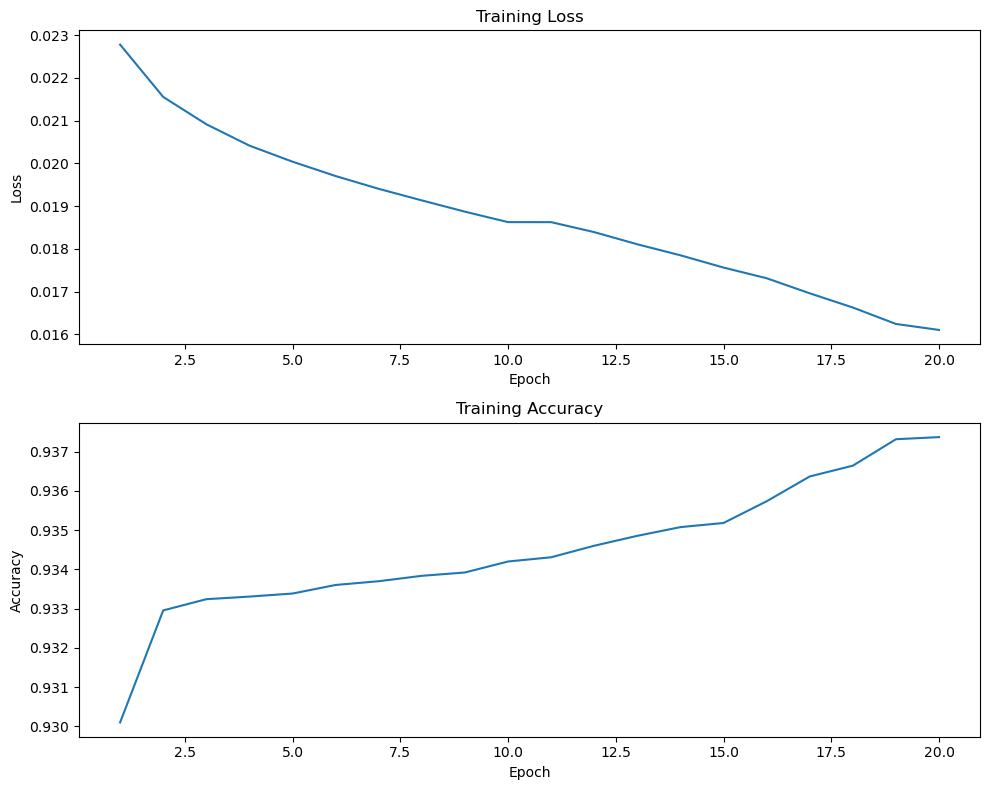

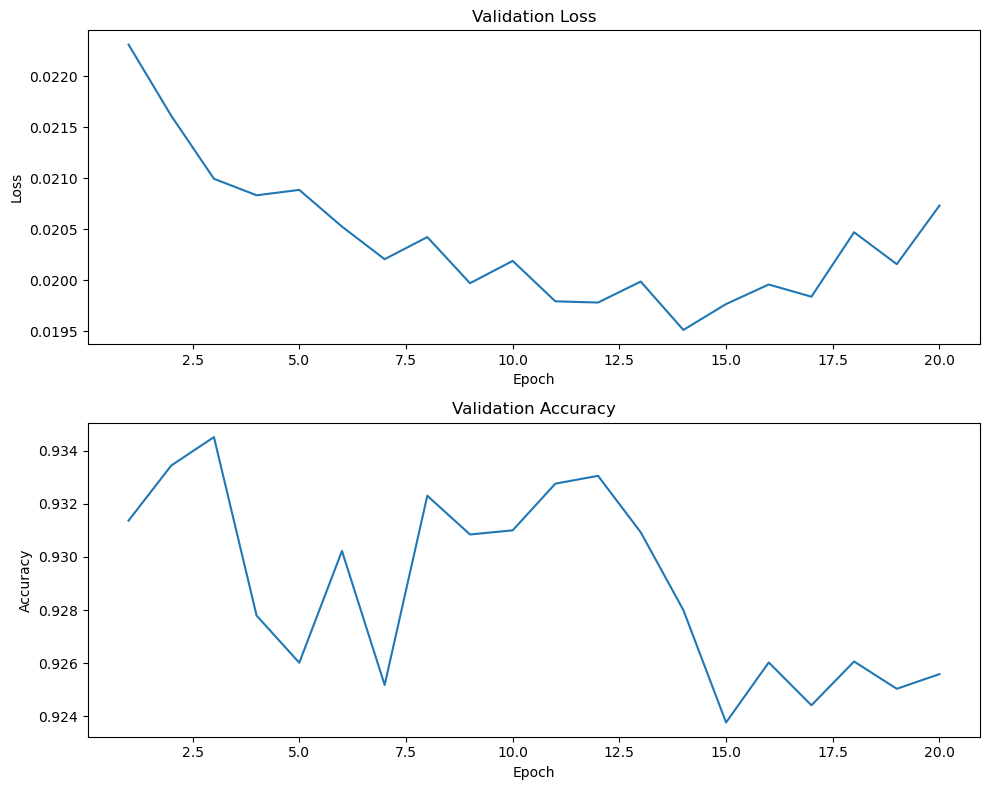

In [29]:
# Visualize the progression of loss and accuracy values during training:
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

plot_loss(axes[0], loss_dict['train'], 'Training Loss')
plot_accuracy(axes[1], acc_dict['train'], 'Training Accuracy')

fig.tight_layout()

fig, axes = plt.subplots(2, 1, figsize=(10, 8))

plot_loss(axes[0], loss_dict['validate'], 'Validation Loss')
plot_accuracy(axes[1], acc_dict['validate'], 'Validation Accuracy')

fig.tight_layout()

In [30]:
# Create modified version of train_model function, which includes sending back all predicted labels (needed to calcualte AUC metric later)
def evaluate_model(model, dataloader,loss_fn, phase = 'validate'):
    
    model.eval()
    
    running_correct = 0
    running_loss = 0
    running_total = 0
    batch_counter = 0
    total_batches = len(dataloader[phase])
    
    all_labels = []
    all_probs = []
    all_preds = []
    
    with torch.no_grad():  # Disable gradient tracking
        for data in dataloader[phase]:
            print(f"Batch {batch_counter}/{total_batches}")
            batch_counter += 1
            image = data[0].to(device)
            metadata = data[1].to(device)
            label = data[2].to(device)
            output = model(image, metadata)
            loss = loss_fn(output, label)
            probs = nn.functional.sigmoid(output)
            preds = torch.round(probs)
            num_imgs = image.size()[0]
            running_correct += torch.sum(preds ==label).item()
            running_loss += loss.item()*num_imgs
            num_classes = label.size()[1]
            running_total += num_imgs*num_classes
    
            # print(f"probs shape: {probs.size()}")
            # print(f"label shape: {label.size()}")
            # print(f"preds shape: {preds.size()}")

            all_labels.append(label.cpu())
            all_probs.append(probs.cpu())
            all_preds.append(preds.cpu())
        
    accuracy = float(running_correct/running_total)
    loss = float(running_loss/running_total)

    all_labels = torch.cat(all_labels, dim=0)
    all_probs = torch.cat(all_probs, dim=0)
    all_preds = torch.cat(all_preds, dim=0)

    print(f"all_labels shape: {all_labels.size()}")
    print(f"all_probs shape: {all_probs.size()}")
    print(f"all_preds shape: {all_preds.size()}")
    
    return all_preds, all_labels, all_probs, accuracy, loss

In [31]:
train_df_weights = (100-train_df_totals) / train_df_totals

print(train_df_weights)

Atelectasis             9.599251
Cardiomegaly           49.364569
Consolidation          29.680417
Edema                  60.980640
Effusion                9.048171
Emphysema              60.412010
Fibrosis               68.662252
Hernia                588.064000
Infiltration            5.271976
Mass                   20.367673
No Finding              0.710128
Nodule                 17.312111
Pleural_Thickening     37.795047
Pneumonia              96.916223
Pneumothorax           32.123257
dtype: float64


In [32]:
def compute_log_pos_weight(train_df, label_names, max_cap=20.0):
    num_samples = len(train_df)
    # print(f"num_samples: {num_samples}")
    num_labels = len(label_names)
    # print(f"num_labels: {num_labels}")
    label_counts = train_df[label_names].sum()
    # print(f"label_counts: {label_counts}")
    # Avoid divide-by-zero and smooth
    weights = (num_samples - label_counts) / (label_counts + 1e-6)
    # print(f"weights: {weights}")
    # Apply log scale and cap
    weights = np.minimum(np.log1p(weights), max_cap)
    # print(f"weights: {weights}")
    return torch.tensor(weights, dtype=torch.float32)


In [33]:
class_weights_raw = torch.tensor(train_df_weights, dtype=torch.float32)
print(class_weights_raw)
class_weights_log = compute_log_pos_weight(train_df, label_names)
print(class_weights_log)

class_pos_weights = torch.tensor(class_weights_log).to(device)

tensor([  9.5993,  49.3646,  29.6804,  60.9806,   9.0482,  60.4120,  68.6623,
        588.0640,   5.2720,  20.3677,   0.7101,  17.3121,  37.7950,  96.9162,
         32.1233])
tensor([2.3608, 3.9193, 3.4236, 4.1268, 2.3074, 4.1176, 4.2437, 6.3785, 1.8361,
        3.0619, 0.5366, 2.9076, 3.6583, 4.5841, 3.5002])


/tmp/ipykernel_3668992/3449950608.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  class_weights_raw = torch.tensor(train_df_weights, dtype=torch.float32)
/tmp/ipykernel_3668992/432158385.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return torch.tensor(weights, dtype=torch.float32)
/tmp/ipykernel_3668992/3449950608.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_pos_weights = torch.tensor(class_weights_log).to(device)


In [34]:
# Predict labels for validation dataset using model:
loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_pos_weights)
eval_dataloader = {'test': val_loader}

val_preds_list, val_labels_list, val_probs_list, val_accuracy, val_loss = evaluate_model(model_resnet_trained, eval_dataloader, loss_fn, 'test')


Batch 0/403
Batch 1/403
Batch 2/403
Batch 3/403
Batch 4/403
Batch 5/403
Batch 6/403
Batch 7/403
Batch 8/403
Batch 9/403
Batch 10/403
Batch 11/403
Batch 12/403
Batch 13/403
Batch 14/403
Batch 15/403
Batch 16/403
Batch 17/403
Batch 18/403
Batch 19/403
Batch 20/403
Batch 21/403
Batch 22/403
Batch 23/403
Batch 24/403
Batch 25/403
Batch 26/403
Batch 27/403
Batch 28/403
Batch 29/403
Batch 30/403
Batch 31/403
Batch 32/403
Batch 33/403
Batch 34/403
Batch 35/403
Batch 36/403
Batch 37/403
Batch 38/403
Batch 39/403
Batch 40/403
Batch 41/403
Batch 42/403
Batch 43/403
Batch 44/403
Batch 45/403
Batch 46/403
Batch 47/403
Batch 48/403
Batch 49/403
Batch 50/403
Batch 51/403
Batch 52/403
Batch 53/403
Batch 54/403
Batch 55/403
Batch 56/403
Batch 57/403
Batch 58/403
Batch 59/403
Batch 60/403
Batch 61/403
Batch 62/403
Batch 63/403
Batch 64/403
Batch 65/403
Batch 66/403
Batch 67/403
Batch 68/403
Batch 69/403
Batch 70/403
Batch 71/403
Batch 72/403
Batch 73/403
Batch 74/403
Batch 75/403
Batch 76/403
Batch 77/

In [35]:
# - - - Save results to files - - -
with open('../../output/inference_results/val_preds_resnet50_log_weights_conv_input.pkl', 'wb') as f:
    pickle.dump(val_preds_list, f)

with open('../../output/inference_results/val_labels_resnet50_log_weights_conv_input.pkl', 'wb') as f:
    pickle.dump(val_labels_list, f)

with open('../../output/inference_results/val_probs_resnet50_log_weights_conv_input.pkl', 'wb') as f:
    pickle.dump(val_probs_list, f)

with open('../../output/inference_results/val_accuracy_resnet50_log_weights_conv_input.pkl', 'wb') as f:
    pickle.dump(val_accuracy, f)

with open('../../output/inference_results/val_loss_resnet50_log_weights_conv_input.pkl', 'wb') as f:
    pickle.dump(val_loss, f)

In [36]:
# Load data from the pickle files
with open('../../output/inference_results/val_preds_resnet50_log_weights_conv_input.pkl', 'rb') as f:
    val_preds_list = pickle.load(f)

with open('../../output/inference_results/val_labels_resnet50_log_weights_conv_input.pkl', 'rb') as f:
    val_labels_list = pickle.load(f)

with open('../../output/inference_results/val_probs_resnet50_log_weights_conv_input.pkl', 'rb') as f:
    val_probs_list = pickle.load(f)

with open('../../output/inference_results/val_accuracy_resnet50_log_weights_conv_input.pkl', 'rb') as f:
    val_accuracy = pickle.load(f)

with open('../../output/inference_results/val_loss_resnet50_log_weights_conv_input.pkl', 'rb') as f:
    val_loss = pickle.load(f)

In [37]:
# Predict labels for testing dataset using model:
loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_pos_weights)
eval_dataloader = {'test': test_loader}

test_preds_list, test_labels_list, test_probs_list, test_accuracy, test_loss = evaluate_model(model_resnet_trained, eval_dataloader, loss_fn, 'test')


Batch 0/800
Batch 1/800
Batch 2/800
Batch 3/800
Batch 4/800
Batch 5/800
Batch 6/800
Batch 7/800
Batch 8/800
Batch 9/800
Batch 10/800
Batch 11/800
Batch 12/800
Batch 13/800
Batch 14/800
Batch 15/800
Batch 16/800
Batch 17/800
Batch 18/800
Batch 19/800
Batch 20/800
Batch 21/800
Batch 22/800
Batch 23/800
Batch 24/800
Batch 25/800
Batch 26/800
Batch 27/800
Batch 28/800
Batch 29/800
Batch 30/800
Batch 31/800
Batch 32/800
Batch 33/800
Batch 34/800
Batch 35/800
Batch 36/800
Batch 37/800
Batch 38/800
Batch 39/800
Batch 40/800
Batch 41/800
Batch 42/800
Batch 43/800
Batch 44/800
Batch 45/800
Batch 46/800
Batch 47/800
Batch 48/800
Batch 49/800
Batch 50/800
Batch 51/800
Batch 52/800
Batch 53/800
Batch 54/800
Batch 55/800
Batch 56/800
Batch 57/800
Batch 58/800
Batch 59/800
Batch 60/800
Batch 61/800
Batch 62/800
Batch 63/800
Batch 64/800
Batch 65/800
Batch 66/800
Batch 67/800
Batch 68/800
Batch 69/800
Batch 70/800
Batch 71/800
Batch 72/800
Batch 73/800
Batch 74/800
Batch 75/800
Batch 76/800
Batch 77/

In [38]:
# - - - Save results to files - - -
with open('../../output/inference_results/test_preds_resnet50_log_weights_conv_input.pkl', 'wb') as f:
    pickle.dump(test_preds_list, f)

with open('../../output/inference_results/test_labels_resnet50_log_weights_conv_input.pkl', 'wb') as f:
    pickle.dump(test_labels_list, f)

with open('../../output/inference_results/test_probs_resnet50_log_weights_conv_input.pkl', 'wb') as f:
    pickle.dump(test_probs_list, f)

with open('../../output/inference_results/test_accuracy_resnet50_log_weights_conv_input.pkl', 'wb') as f:
    pickle.dump(test_accuracy, f)

with open('../../output/inference_results/test_loss_resnet50_log_weights_conv_input.pkl', 'wb') as f:
    pickle.dump(test_loss, f)

In [39]:
# Load data from the pickle files
with open('../../output/inference_results/test_preds_resnet50_log_weights_conv_input.pkl', 'rb') as f:
    test_preds_list = pickle.load(f)

with open('../../output/inference_results/test_labels_resnet50_log_weights_conv_input.pkl', 'rb') as f:
    test_labels_list = pickle.load(f)

with open('../../output/inference_results/test_probs_resnet50_log_weights_conv_input.pkl', 'rb') as f:
    test_probs_list = pickle.load(f)

with open('../../output/inference_results/test_accuracy_resnet50_log_weights_conv_input.pkl', 'rb') as f:
    test_accuracy = pickle.load(f)

with open('../../output/inference_results/test_loss_resnet50_log_weights_conv_input.pkl', 'rb') as f:
    test_loss = pickle.load(f)

In [40]:
results_dict = {}

for idx, label in enumerate(label_names):
    results_dict[f"predicted_{label}"] = test_preds_list[:,idx].bool()
    results_dict[f"label_{label}"] = test_labels_list[:,idx].bool()
    results_dict[f"prob_{label}"] = test_probs_list[:,idx]

results_df = pd.DataFrame(results_dict)
print(results_df)

       predicted_Atelectasis  label_Atelectasis  prob_Atelectasis  \
0                      False              False          0.054529   
1                      False              False          0.462146   
2                      False              False          0.206274   
3                      False              False          0.387861   
4                      False              False          0.297887   
...                      ...                ...               ...   
25591                  False              False          0.021610   
25592                  False              False          0.003332   
25593                  False              False          0.007636   
25594                  False              False          0.019544   
25595                  False              False          0.018802   

       predicted_Cardiomegaly  label_Cardiomegaly  prob_Cardiomegaly  \
0                       False               False           0.001990   
1                       Fal

In [41]:
from sklearn.metrics import recall_score, precision_score, f1_score

y_true = test_labels_list.numpy().astype(int)
print(y_true)

y_pred = test_preds_list.numpy().astype(int)
print(y_pred)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [42]:
# Compute recall: tp / (tp + fn)
recall_per_class = recall_score(y_true, y_pred, average=None)  # or 'macro' or 'micro', 'samples', 'weighted'
# print("Recall score:", recall)

# Compute precision: tp / (tp + fp)
precision_per_class = precision_score(y_true, y_pred, average=None)

# Compute F-1 score: tp / (tp + fp)
f1score_per_class = f1_score(y_true, y_pred, average=None)

df_class_scores = pd.DataFrame(columns=label_names, index=['Recall','Precision','F-1 Score'])

df_class_scores.loc['Recall'] = recall_per_class
df_class_scores.loc['Precision'] = precision_per_class
df_class_scores.loc['F-1 Score'] = f1score_per_class

# Display dataframe:
df_class_scores

,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
Recall,0.350107,0.335828,0.130028,0.165405,0.597037,0.419945,0.011494,0.360465,0.329025,0.407895,0.353007,0.248306,0.144357,0.0,0.349719
Precision,0.348195,0.407491,0.218721,0.183014,0.439406,0.322331,0.16129,0.418919,0.428602,0.303922,0.7533,0.253141,0.168712,0.0,0.421338
F-1 Score,0.349148,0.368205,0.163096,0.173765,0.506235,0.36472,0.021459,0.3875,0.37227,0.348315,0.480735,0.2507,0.155587,0.0,0.382202


In [56]:
# Macro
recall_macro = recall_score(y_true, y_pred, average='macro')
precision_macro = precision_score(y_true, y_pred, average='macro')
f1score_macro = f1_score(y_true, y_pred, average='macro')

# Micro
recall_micro = recall_score(y_true, y_pred, average='micro')
precision_micro = precision_score(y_true, y_pred, average='micro')
f1score_micro = f1_score(y_true, y_pred, average='micro')

data = {'Macro' : [recall_macro, precision_macro, f1score_macro], 'Micro': [recall_micro, precision_micro, f1score_micro]}
df_avg_scores = pd.DataFrame(data, index=['Recall','Precision','F-1 Score'])
df_avg_scores.round({'Macro': 4, 'Micro': 4, 'Weighted': 4})


,Macro,Micro
Recall,0.2802,0.3474
Precision,0.3219,0.4237
F-1 Score,0.2883,0.3818


In [44]:
test_df_totals = test_df[label_names].sum()/len(test_df)*100

print(f"Percentage of positive cases in testing dataset:")
test_df_totals

Percentage of positive cases in testing dataset:


Atelectasis           12.810595
Cardiomegaly           4.176434
Consolidation          7.090952
Edema                  3.613846
Effusion              18.198156
Emphysema              4.270198
Fibrosis               1.699484
Hernia                 0.335990
Infiltration          23.878731
Mass                   6.829192
No Finding            38.525551
Nodule                 6.340835
Pleural_Thickening     4.465541
Pneumonia              2.168308
Pneumothorax          10.411783
dtype: float64

In [45]:
columns = ["predicted_" + s for s in label_names]

preds_df_totals = results_df[columns].sum()/len(results_df)*100

print(f"Percentage of predicted positive cases for the testing dataset:")
preds_df_totals

Percentage of predicted positive cases for the testing dataset:


predicted_Atelectasis           12.880919
predicted_Cardiomegaly           3.441944
predicted_Consolidation          4.215502
predicted_Edema                  3.266135
predicted_Effusion              24.726520
predicted_Emphysema              5.563369
predicted_Fibrosis               0.121113
predicted_Hernia                 0.289108
predicted_Infiltration          18.330989
predicted_Mass                   9.165495
predicted_No Finding            18.053602
predicted_Nodule                 6.219722
predicted_Pleural_Thickening     3.820910
predicted_Pneumonia              0.003907
predicted_Pneumothorax           8.641975
dtype: float64

In [46]:
# exact match ratio
exact_correct = np.all(y_true == y_pred, axis=1)
print(f"Exact match percentage: {sum(exact_correct)/len(test_ds)*100:.2f}%")

Exact match percentage: 19.69%


In [47]:
# Calculate optimal operating point thresholds based on validation dataset:

from sklearn.metrics import precision_recall_curve, f1_score

num_labels = len(label_names)

probs = val_probs_list.numpy()
labels = val_labels_list.numpy().astype(int)

# Before threshold tuning:
preds = (probs >= 0.5).astype(int)
f1_macro = f1_score(labels, preds, average='macro')
f1_micro = f1_score(labels, preds, average='micro')
print(f"F1 Macro: {f1_macro:.4f}")
print(f"F1 Micro: {f1_micro:.4f}")

# Find optimal threshold per label using PR curve + F1
optimal_thresholds = []
for i in range(num_labels):
    precision, recall, thresholds = precision_recall_curve(labels[:, i], probs[:, i])
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_idx] if best_idx < len(thresholds) else 0.5
    optimal_thresholds.append(best_threshold)

optimal_thresholds = np.array(optimal_thresholds)
print("Optimal thresholds per label:", optimal_thresholds)

# Apply thresholds for updated predictions
preds = (probs >= optimal_thresholds).astype(int)

# Evaluate F1 score after threshold tuning
f1_macro = f1_score(labels, preds, average='macro')
f1_micro = f1_score(labels, preds, average='micro')
print(f"F1 Macro (tuned): {f1_macro:.4f}")
print(f"F1 Micro (tuned): {f1_micro:.4f}")


F1 Macro: 0.2763
F1 Micro: 0.5087
Optimal thresholds per label: [0.37373587 0.42948225 0.23818882 0.3953799  0.43381542 0.4492992
 0.13543223 0.8019277  0.28199315 0.5323881  0.23209056 0.44848466
 0.29732794 0.220884   0.3903145 ]
F1 Macro (tuned): 0.3256
F1 Micro (tuned): 0.5303


In [48]:
def predict_with_thresholds(probs, thresholds):
    adjusted_predictions = (probs >= torch.tensor(thresholds, device=probs.device)).float()
    
    return adjusted_predictions

In [49]:
# Recalculate results for test dataset
f1_macro = f1_score(y_true, y_pred, average='macro')
f1_micro = f1_score(y_true, y_pred, average='micro')
print(f"F1 Macro (original): {f1_macro:.4f}")
print(f"F1 Micro (original): {f1_micro:.4f}")

test_preds_list_tuned = predict_with_thresholds(test_probs_list, optimal_thresholds)
y_pred_tuned = test_preds_list_tuned.numpy().astype(int)

f1_macro = f1_score(y_true, y_pred_tuned, average='macro')
f1_micro = f1_score(y_true, y_pred_tuned, average='micro')
print(f"F1 Macro (tuned): {f1_macro:.4f}")
print(f"F1 Micro (tuned): {f1_micro:.4f}")

F1 Macro (original): 0.2883
F1 Micro (original): 0.3818
F1 Macro (tuned): 0.3253
F1 Micro (tuned): 0.4155


In [50]:
# Compute recall: tp / (tp + fn)
recall_per_class = recall_score(y_true, y_pred_tuned, average=None)  # or 'macro' or 'micro', 'samples', 'weighted'
# print("Recall score:", recall)

# Compute precision: tp / (tp + fp)
precision_per_class = precision_score(y_true, y_pred_tuned, average=None)

# Compute F-1 score: tp / (tp + fp)
f1score_per_class = f1_score(y_true, y_pred_tuned, average=None)

df_class_scores_tuned = pd.DataFrame(columns=label_names, index=['Recall','Precision','F-1 Score'])

df_class_scores_tuned.loc['Recall'] = recall_per_class
df_class_scores_tuned.loc['Precision'] = precision_per_class
df_class_scores_tuned.loc['F-1 Score'] = f1score_per_class

# Display dataframe:
df_class_scores_tuned

,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
Recall,0.531869,0.388213,0.573554,0.286486,0.670245,0.436414,0.216092,0.244186,0.715151,0.378719,0.636244,0.296981,0.410324,0.133333,0.481426
Precision,0.282429,0.38785,0.143665,0.162278,0.409443,0.302857,0.087442,0.5,0.331689,0.322141,0.568143,0.230732,0.134307,0.05343,0.382757
F-1 Score,0.368944,0.388032,0.229776,0.207193,0.508345,0.357571,0.124503,0.328125,0.453188,0.348146,0.600268,0.259698,0.202373,0.076289,0.426458


In [55]:
# Macro
recall_macro = recall_score(y_true, y_pred_tuned, average='macro')
precision_macro = precision_score(y_true, y_pred_tuned, average='macro')
f1score_macro = f1_score(y_true, y_pred_tuned, average='macro')

# Micro
recall_micro = recall_score(y_true, y_pred_tuned, average='micro')
precision_micro = precision_score(y_true, y_pred_tuned, average='micro')
f1score_micro = f1_score(y_true, y_pred_tuned, average='micro')

data = {'Macro' : [recall_macro, precision_macro, f1score_macro], 'Micro': [recall_micro, precision_micro, f1score_micro]}
df_avg_scores_tuned = pd.DataFrame(data, index=['Recall','Precision','F-1 Score'])
df_avg_scores_tuned.round({'Macro': 4, 'Micro': 4, 'Weighted': 4})

,Macro,Micro
Recall,0.4266,0.5610
Precision,0.2866,0.3299
F-1 Score,0.3253,0.4155


In [52]:
# Calculate AUC-ROC:

from sklearn.metrics import roc_auc_score

# y_true: [batch_size, num_labels], binary (0 or 1)
# y_pred: [batch_size, num_labels], probabilities from model (sigmoid output)

y_probs = test_probs_list

macro_auc = roc_auc_score(y_true, y_probs, average='macro')
micro_auc = roc_auc_score(y_true, y_probs, average='micro')
weighted_auc = roc_auc_score(y_true, y_probs, average='weighted')

print("Macro AUC:", macro_auc)
print("Micro AUC:", micro_auc)
print("Weighted AUC:", weighted_auc)


Macro AUC: 0.77995646121284
Micro AUC: 0.837330075157523
Weighted AUC: 0.7553538948802979


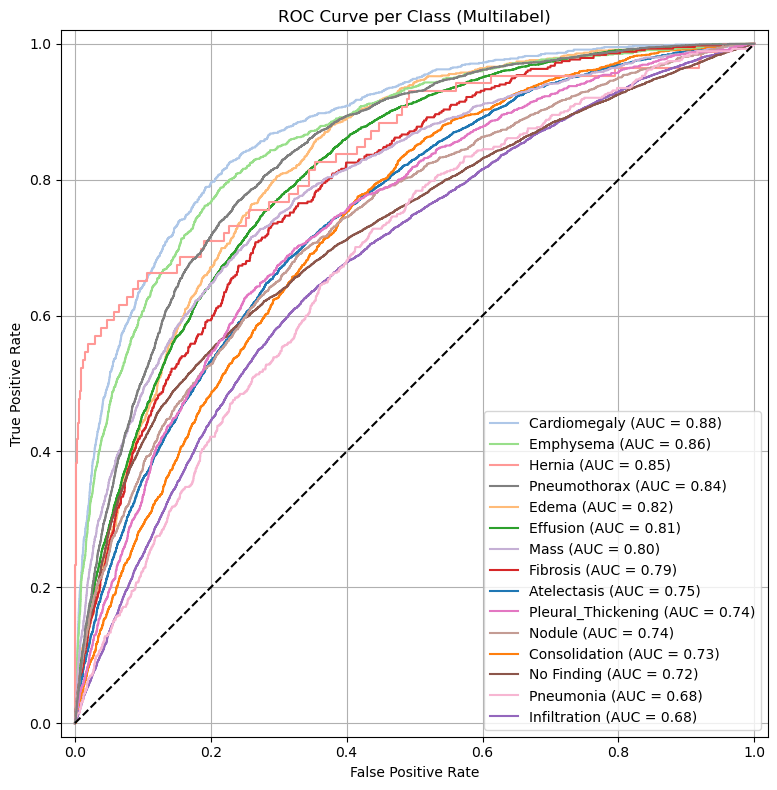

In [53]:
# Plot ROC curves:

from sklearn.metrics import roc_curve, auc

# Plotting setup
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot()
cmap=plt.get_cmap('tab20')

roc_auc_list = []

for i in range(num_labels):
    fpr, tpr, _ = roc_curve(y_true[:, i], y_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{label_names[i]} (AUC = {roc_auc:.2f})", color=cmap(i))
    roc_auc_list.append(roc_auc)

# Chance line
plt.plot([0, 1], [0, 1], 'k--')
# plt.plot([0, 1], [0, 1], 'k--', label='Chance (AUC = 0.5)')
plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
ax.set_aspect('equal')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve per Class (Multilabel)')

plt.legend(loc='lower right')
handles, labels = plt.gca().get_legend_handles_labels()
order = np.argsort(roc_auc_list)[::-1]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])


plt.grid(True)
plt.tight_layout()
plt.savefig('../../output/inference_results/model-7-log-weights-roc-auc-1.png', dpi=300)
plt.show()


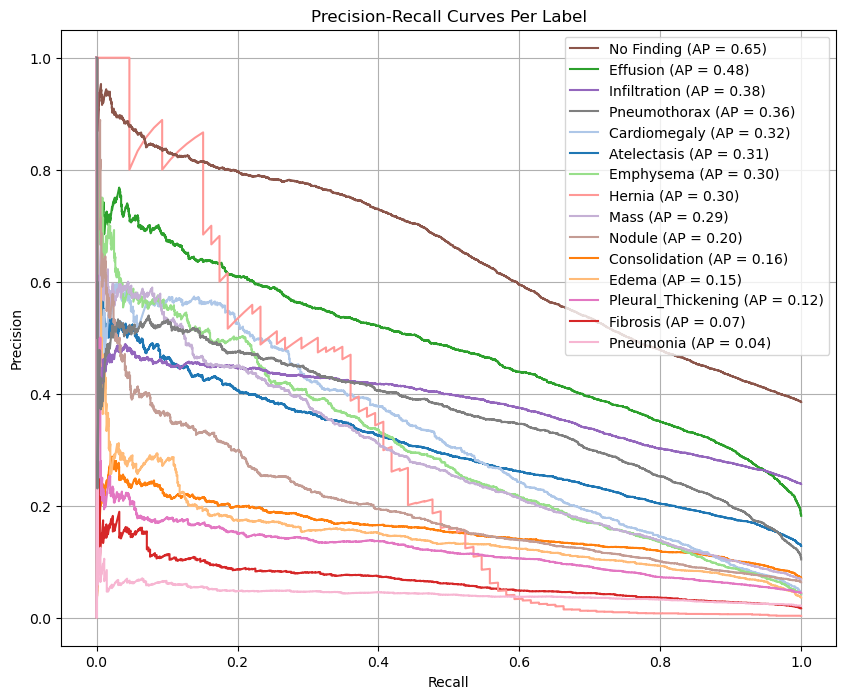

In [54]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Create a figure
plt.figure(figsize=(10, 8))
cmap=plt.get_cmap('tab20')
ap_score_list = []

for i in range(num_labels):
    precision, recall, _ = precision_recall_curve(y_true[:, i], y_probs[:, i])
    ap_score = average_precision_score(y_true[:, i], y_probs[:, i])
    ap_score_list.append(ap_score)
    
    plt.plot(recall, precision, label=f'{label_names[i]} (AP = {ap_score:.2f})', color=cmap(i))

# Plot settings
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves Per Label')

plt.legend(loc='best')
handles, labels = plt.gca().get_legend_handles_labels()
order = np.argsort(ap_score_list)[::-1]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])

plt.grid(True)
plt.savefig('../../output/inference_results/model-7-log-weights-prc-1.png', dpi=300)
plt.show()